<a href="https://colab.research.google.com/github/hemanths03/CS6910_Assignment_3/blob/main/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Required Libraries

In [ ]:
import pandas as pd
import numpy as np
from random import sample
import random

from tensorflow import keras
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

from IPython.display import HTML
from IPython.display import display
import ast

#WandB Login

In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

from wandb.keras import WandbCallback

wandb: Currently logged in as: hemanth_cs21m027 (cs21m027_cs21m011). Use `wandb login --relogin` to force relogin


#Mounting the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Load the datasets

In [ ]:
train_dataset = pd.read_csv('/content/gdrive/MyDrive/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv', sep = '\t', header = None)
val_dataset = pd.read_csv('/content/gdrive/MyDrive/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv', sep = '\t', header = None)
test_dataset = pd.read_csv('/content/gdrive/MyDrive/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv', sep = '\t', header = None)

#Preprocessing the dataset into required format

In [ ]:
def preprocess_data():

    #Declaring some required variables

    train_input_lexicons = []
    train_target_lexicons = []
    val_input_lexicons = []
    val_target_lexicons = []
    test_input_lexicons = []
    test_target_lexicons = []

    #Splitting the datasets in input_lexicons and target_lexicons

    for i in range(len(train_dataset)):
      train_input_lexicons.append(str(train_dataset[1][i]))
      train_target_lexicons.append("\t" + str(train_dataset[0][i])+"\n")

    for i in range(len(val_dataset)):
      val_input_lexicons.append(str(val_dataset[1][i]))
      val_target_lexicons.append("\t" + str(val_dataset[0][i])+"\n")

    for i in range(len(test_dataset)):
      test_input_lexicons.append(str(test_dataset[1][i]))
      test_target_lexicons.append("\t" + str(test_dataset[0][i])+"\n")


    #Creating unique input and target character sets

    input_characters = set()
    input_characters.add(' ')
    target_characters = set()
    target_characters.add(' ')

    #union of all input words

    ip_words = train_input_lexicons + val_input_lexicons + test_input_lexicons

    #Union of all target words

    op_words = train_target_lexicons + val_target_lexicons + test_target_lexicons

    #Adding unique characters in their respective sets

    for word in ip_words:
      for char in word:
        input_characters.add(char)

    for word in op_words:
      for char in word:
        target_characters.add(char)

    #Sorting the list

    input_characters = sorted(list(input_characters))
    num_encoder_tokens = len(input_characters)

    target_characters = sorted(list(target_characters))
    num_decoder_tokens = len(target_characters)

    #Find the max sequence length input and target

    max_encoder_seq_length = max([len(word) for word in ip_words])
    max_decoder_seq_length = max([len(word) for word in op_words])

    #Printing the summary :

    print("Summary of the dataset :")
    print("Number of train samples :" , len(train_input_lexicons))
    print("Number of val samples :" , len(val_input_lexicons))
    print("Number of test samples :" , len(test_input_lexicons))
    print("Number of unique input tokens :" , num_encoder_tokens)
    print("Number of unique output tokens :" , num_decoder_tokens)
    print("Max sequence length for inputs:" , max_encoder_seq_length)
    print("Max sequence length for outputs:" , max_decoder_seq_length)

    #Creating a dictionary for input words and target words

    input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
    target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])


    encoder_train_input_data = np.zeros((len(train_input_lexicons), max_encoder_seq_length), dtype="float32")

    encoder_val_input_data = np.zeros((len(val_input_lexicons), max_encoder_seq_length), dtype="float32")

    encoder_test_input_data = np.zeros((len(test_input_lexicons), max_encoder_seq_length), dtype="float32")


    decoder_train_input_data = np.zeros((len(train_input_lexicons), max_decoder_seq_length), dtype="float32")
    decoder_train_target_data = np.zeros((len(train_input_lexicons), max_decoder_seq_length, num_decoder_tokens ), dtype="float32")

   
    decoder_val_input_data = np.zeros((len(val_input_lexicons), max_decoder_seq_length), dtype="float32")
    decoder_val_target_data = np.zeros((len(val_input_lexicons), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

    
    #TRAIN DATA

    for i, (input_text, target_text) in enumerate(zip(train_input_lexicons, train_target_lexicons)):
      for t, char in enumerate(input_text):
          encoder_train_input_data[i, t] = input_token_index[char]
      encoder_train_input_data[i, t + 1 :] = input_token_index[' ']
      for t, char in enumerate(target_text):
          # decoder_target_data is ahead of decoder_input_data by one timestep
          decoder_train_input_data[i, t] = target_token_index[char]
          if t > 0:
              # decoder_target_data will be ahead by one timestep
              # and will not include the start character.
              decoder_train_target_data[i, t - 1, target_token_index[char]] = 1.0
      decoder_train_input_data[i, t + 1 :] = target_token_index[' ']
      decoder_train_target_data[i, t:, target_token_index[' ']] = 1.0

    #VALIDATION DATA

    for i, (input_text, target_text) in enumerate(zip(val_input_lexicons, val_target_lexicons)):
      for t, char in enumerate(input_text):
          encoder_val_input_data[i, t] = input_token_index[char]
      encoder_val_input_data[i, t + 1 :] = input_token_index[' ']
      for t, char in enumerate(target_text):
          # decoder_target_data is ahead of decoder_input_data by one timestep
          decoder_val_input_data[i, t] = target_token_index[char]
          if t > 0:
              # decoder_target_data will be ahead by one timestep
              # and will not include the start character.
              decoder_val_target_data[i, t - 1, target_token_index[char]] = 1.0
      decoder_val_input_data[i, t + 1 :] = target_token_index[' ']
      decoder_val_target_data[i, t:, target_token_index[' ']] = 1.0

    #TEST DATA

    for i, input_text in enumerate(test_input_lexicons):
      for t, char in enumerate(input_text):
          encoder_test_input_data[i, t] = input_token_index[char]
      encoder_test_input_data[i, t + 1 :] = input_token_index[' ']
      

    inverse_input_token_index = dict((i, char) for char, i in input_token_index.items())
    inverse_target_token_index = dict((i, char) for char, i in target_token_index.items())

    return ((encoder_train_input_data , encoder_val_input_data , encoder_test_input_data),
    (decoder_train_input_data , decoder_val_input_data),
    (decoder_train_target_data , decoder_val_target_data),
    (val_input_lexicons , test_input_lexicons),
    (val_target_lexicons , test_target_lexicons),
    (num_encoder_tokens , num_decoder_tokens),
    (max_encoder_seq_length , max_decoder_seq_length),
    (target_token_index , inverse_input_token_index , inverse_target_token_index))

#Load the preprocessed data

In [ ]:
((encoder_train_input_data , encoder_val_input_data , encoder_test_input_data),
 (decoder_train_input_data , decoder_val_input_data),
 (decoder_train_target_data , decoder_val_target_data),
 (val_input_lexicons , test_input_lexicons),
 (val_target_lexicons , test_target_lexicons),
 (num_encoder_tokens , num_decoder_tokens),
 (max_encoder_seq_length , max_decoder_seq_length),
 (target_token_index , inverse_input_token_index , inverse_target_token_index)) = preprocess_data()

Summary of the dataset :
Number of train samples : 58550
Number of val samples : 5683
Number of test samples : 5747
Number of unique input tokens : 27
Number of unique output tokens : 66
Max sequence length for inputs: 25
Max sequence length for outputs: 22


#Some functions for Visualization Purpose

In [ ]:
#Set ehe color
def cstr(s, color = 'black'):
    return "<text style=color:#000;padding-top:1.5px;padding-bottom:1.5px;padding-left:2.5px;padding-right:2.5px;background-color:{}>{} </text>".format(color, s)

In [ ]:
#Get color function
def get_clr(value, mode):
    if(mode == 'l'):
        colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8', '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8', '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f', '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
        value = int((value * 100) / 5)
        return colors[value]
    else:
        colors = ['#ffffff', '#ecf7fb', '#daeff7', '#c7e7f3', '#b5dfef', '#a2d7eb', '#90cfe7', '#7dc7e3', '#6abfdf', '#58b7db', '#46afd7']
        value = int((value * 100) / 10)
        return colors[value]

In [ ]:
def visualize_c(dec_char, text_colours):
    if (dec_char == "<e>"):
      display(HTML(''.join([cstr(ti, color = ci) for ti, ci in text_colours]) + " <b> &emsp; &lt; e &gt; </b>  &emsp; &nbsp; "))
    else:
      display(HTML(''.join([cstr(ti, color = ci) for ti, ci in text_colours]) + " <b> &emsp; {}</b>  &emsp; &emsp; ".format(dec_char)))

In [ ]:
def visualize_l(dec_seq, prob):
    text_colours = []

    for c, p in zip(dec_seq, prob): 
        text = (c, get_clr(p, 'l'))
        text_colours.append(text)
    
    display(HTML(''.join([cstr(ti, color = ci) for ti, ci in text_colours])))

#Connectivity Visualization function

In [ ]:
def visualize_connectivity(N):

    # Reading from conv_vis file
    with open("visualize.txt", "r", encoding='utf-8') as filepointer:
        
        lines = filepointer.readlines()

        i = 0
        words_visualized = 0

        while i < len(lines) and  words_visualized< N:
            line = lines[i]
            
            if line[:4] == "Next":
                words_visualized += 1
                i += 1
                continue

            if line[:4] != "Next": 
                true_word, dec_char_len = line.split('\t') 
                dec_word_len = int(dec_char_len)
                i += 1

                true_word_array = [c for c in true_word]

                for j in range(dec_word_len):
                    line = lines[i]
                    line = line.split('\t')
  
                    dec_char = line[0]
                    text_colours = []

                    prob = []
                    for prob_index in range(1,len(true_word)+1) :
                        p = float(line[prob_index])
                        prob.append(p)

                    line = softmax(prob)

                    
                    for prob_index in range(len(true_word)) :
                        p = float(line[prob_index])

                        true_char = true_word_array[prob_index]
                        text= (true_char, get_clr(p, 'c') )
                        text_colours.append(text)

                    visualize_c(dec_char, text_colours)
            
                    i += 1

            print("\n\n")

#LSTM Visualization function

In [ ]:
def visualize_lstm(N, neuron):

    for i in range(N):

        file = open("lstm_viz_" + str(i) + ".txt", "r")
        input_seq = file.readline()[:-1]
        
        dec_seq = []
        prob = []

        for line in file:
            temp = line.split('\t')
            dec_seq.append(temp[0])
            prob.append(ast.literal_eval(temp[1][:-1])[neuron - 1])

        visualize_l(dec_seq, prob)
        print()

#Function to plot the heatmaps

In [ ]:
def plot_heatmap(input_word, heatmap_data):
    mats = []
    dec_inputs = []

    for data in heatmap_data:
        dec_ind, attn  = data[0], data[1]
        mats.append(attn.reshape(-1)[:len(input_word)])
        dec_inputs.append(dec_ind)
    
    attention_mat = np.array(mats)

    fig, ax = plt.subplots()
    ax.imshow(attention_mat)

    ax.set_xticks(np.arange(attention_mat.shape[1]))
    ax.set_yticks(np.arange(attention_mat.shape[0]))

    ax.set_yticklabels([inp if inp != '\n' else "<e>" for inp in dec_inputs], fontproperties = FontProperties(fname = "/content/gdrive/MyDrive/Fonts/nirmala.ttf"))
    ax.set_xticklabels([char for char in input_word])

    ax.tick_params(labelsize = 15)
    ax.tick_params(axis = 'x', labelrotation =  45)

    return fig

#Sigmoid function

In [ ]:
#Sigmoid function
def sigmoid(x):
    temp = []
    for i in range(len(x)):
      temp.append(1/(1 + np.exp(-x[i])))
    return list(temp)

#Softmax Function

In [ ]:
#Softmax function
def softmax(x):
    denom = sum([np.exp(i) for i in x])
    return [np.exp(i) / denom for i in x]

#Building an Attention layer

In [ ]:
import tensorflow as tf
class AttentionLayer(Layer):

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.W_a = self.add_weight(name='W_a',
                                   shape = tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer = 'uniform',
                                   trainable = True)

        self.U_a = self.add_weight(name = 'U_a',
                                   shape = tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer = 'uniform',
                                   trainable = True)

        self.V_a = self.add_weight(name = 'V_a',
                                   shape = tf.TensorShape((input_shape[0][2], 1)),
                                   initializer = 'uniform',
                                   trainable = True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
       
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        encoder_out_seq, decoder_out_seq = inputs

        def energy_step(inputs, states):
           
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)
            
            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)

            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

#Decode sequence

In [ ]:
def decode_sequence(input_seq , encoder_model , decoder_model , target_token_index , inverse_target_token_index , max_decoder_seq_length):

    #Declare heatmapss data and viz_data
    heatmap_data = []
    viz_data = []

    #Encode the input as state vectors.
    encoder_outputs = encoder_model.predict(input_seq)
    encoder_output , states_value = encoder_outputs[0] , encoder_outputs[1:]

    #Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    #Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index["\t"]
        
    #Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ""  

    while not stop_condition:

          output = decoder_model.predict([target_seq] + states_value + [encoder_output])
          output_tokens, states_value, attention_weights = output[0], output[1:-1], output[-1]

          #Sampling a token
          sampled_token_index = np.argmax(output_tokens[0, -1, :])
          sampled_char = inverse_target_token_index[sampled_token_index]
          decoded_sentence += sampled_char

          if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
              stop_condition = True

          target_seq = np.zeros((1, 1))
          target_seq[0, 0] = sampled_token_index
          heatmap_data.append((sampled_char,attention_weights))
          viz_data.append((sampled_char,states_value[0]))

    return decoded_sentence , heatmap_data , viz_data

#Inference call to calculate the accuracy
1.)encode input and retrieve initial decoder state

2.)run one step of decoder with this initial state and a "start of sequence" token as target. Output will be the next target token.

3.)Repeat with the current target token and current states

In [ ]:
def run_inference(encoder_test_input_data, test_input_lexicons, test_target_lexicons, num_decoder_tokens, max_decoder_seq_length, target_token_index, inverse_target_token_index, latent_dim ,cell_type ,samples):
      # Define sampling models
      # Restore the model and construct the encoder and decoder.
      model = keras.models.load_model("seq2seq_2")

      #Declare index variable for encoder embedding and decoder embedding 

      count = 0
      vc = 0
      size_ = len(test_input_lexicons)
      maps = []
      viz_inputs = sample(range(size_),samples)

      predictions_attention_RNN = open("predictions_attention_RNN.csv", "w", encoding='utf-8')
      predictions_attention_RNN.write("Input Word,Predicted Word,True Word\n")

      #Defining the encoder
      encoder_inputs = model.input[0] #input_1

      if cell_type == "rnn" or cell_type == "gru" :
        encoder_outputs , state = model.layers[4].output
        encoder_model = keras.Model(encoder_inputs , [encoder_outputs] + [state])
      elif cell_type == "lstm" :
        encoder_outputs , state_h_enc , state_c_enc = model.layers[4].output
        encoder_model = keras.Model(encoder_inputs , [encoder_outputs] + [state_h_enc , state_c_enc])
      else :
         print("Write the Required cell type encoder definition here...!")
         return

      #Defining the Decoder
      decoder_inputs = model.input[1]  # input_2
      decoder_outputs =  model.layers[3](decoder_inputs)

      '''decoder_states_inputs =  []
      decoder_states = []'''

      #Decoder
      if cell_type == "rnn" or cell_type == "gru":
          state = keras.Input(shape = (latent_dim, ))
          current_states_inputs = [state]
          decoder_outputs, state = model.layers[5](decoder_outputs, initial_state = current_states_inputs)
          decoder_states = [state]

      elif cell_type == "lstm":
          state_h_dec, state_c_dec = keras.Input(shape = (latent_dim,)),  keras.Input(shape = (latent_dim,))
          current_states_inputs = [state_h_dec, state_c_dec]
          decoder_outputs, state_h_dec,state_c_dec = model.layers[5](decoder_outputs, initial_state = current_states_inputs)
          decoder_states = [state_h_dec, state_c_dec]


      #Attention
      attention_inputs = keras.Input(shape = (None, latent_dim, ))
      attention_output, attention_scores = model.layers[6]([attention_inputs, decoder_outputs])
      decoder_input_concate = model.layers[7]([decoder_outputs, attention_output])


      # Dense layer
      decoder_outputs = model.layers[8](decoder_input_concate)

      # Decoder model
      decoder_model = keras.Model([decoder_inputs] + current_states_inputs + [attention_inputs] , [decoder_outputs] + decoder_states + [attention_scores])


      for seq_index in range(size_): 
       
          input_seq = encoder_test_input_data[seq_index : seq_index + 1]

          decoded_word , heatmap_data , viz_data = decode_sequence(input_seq , encoder_model , decoder_model , target_token_index , inverse_target_token_index , max_decoder_seq_length)

          orig_word = test_target_lexicons[seq_index][1:]

          predictions_attention_RNN.write(test_input_lexicons[seq_index] + "," + decoded_word[:-1] + "," + orig_word[:-1] + "\n")
          
          if(orig_word == decoded_word): count += 1

          if seq_index in viz_inputs:
            #Plot the heatmap
            hmap = plot_heatmap(test_input_lexicons[seq_index] , heatmap_data)
            maps.append(hmap)

            #Visualize the connectivity
            with open("visualize.txt" , "a" , encoding="utf-8") as filepointer:
              #Compute heatmap and true word
              true_word = test_input_lexicons[seq_index]

              #Writing data into the conv_vis.txt file for visualisation purpose
              filepointer.write(true_word)
              filepointer.write("\t")
              filepointer.write(str(len(heatmap_data)))
              filepointer.write("\n")

              for tup in range(len(heatmap_data)):
                  dec_char = heatmap_data[tup][0]
                  dec_char_prob = heatmap_data[tup][1].reshape(-1)
                
                  if tup == len(heatmap_data) - 1:
                      filepointer.write("<e>")
                  else:
                      filepointer.write(dec_char)
                    
                  filepointer.write("\t")

                  for p in range(len(true_word)):
                      filepointer.write(str(dec_char_prob[p]))
                      filepointer.write("\t")

                  filepointer.write("\n")

              filepointer.write("Next\n")

            #LSTM VISUALIZATION
            file = open("lstm_viz_" + str(vc) + ".txt", "w", encoding='utf-8')
            file.write(test_input_lexicons[seq_index] + "\n")

            for i, data in enumerate(viz_data):
              dec_char, neuron_activation  = data[0], sigmoid(data[1].reshape(-1))
              if i == len(viz_data) - 1:
                  file.write("<e>" + "\t" + str(neuron_activation) + "\n")
              else:
                  file.write(dec_char + "\t" + str(neuron_activation) + "\n")

            vc += 1


      return count / size_ , maps

#Building an RNN Model

In [ ]:
def train():

    np.random.seed(77)

    #Initializing WandB
    run = wandb.init()
    config = run.config

    #Setting up the Run name
    name = "ES_" + str(config.embedding_size) + "_CT_" + config.cell_type + "_DO_" + str(config.dropout) + "_BS_" + str(config.beam_size)
    run.name = name

    #Number of samples to visualize
    samples = 10

    #Define input sequence and Setting the Encoder
    encoder_inputs = keras.Input(shape =(None, ))
    encoder_outputs = keras.layers.Embedding(input_dim = num_encoder_tokens, output_dim = config.embedding_size, input_length = max_encoder_seq_length)(encoder_inputs)

    #Setting the Decoder
    decoder_inputs = keras.Input(shape=(None, ))
    decoder_outputs = keras.layers.Embedding(input_dim = num_decoder_tokens, output_dim = config.embedding_size, input_length = max_decoder_seq_length)(decoder_inputs)

    # We discard encoder_outputs and only keep the states.
    # Set up the decoder, using encoder_states as initial state.
    encoder_states = list()

    if config.cell_type == "rnn":
        encoder_outputs, state = keras.layers.SimpleRNN(config.hidden_layer_size, dropout = config.dropout, return_state = True, recurrent_dropout = config.recurrent_dropout, return_sequences = True)(encoder_outputs)
        encoder_states = [state]
    if config.cell_type == "lstm":
        encoder_outputs, state_h, state_c = keras.layers.LSTM(config.hidden_layer_size, dropout = config.dropout, return_state = True, recurrent_dropout = config.recurrent_dropout, return_sequences = True)(encoder_outputs)
        encoder_states = [state_h,state_c]
    if config.cell_type == "gru":
        encoder_outputs, state = keras.layers.GRU(config.hidden_layer_size, dropout = config.dropout, return_state = True, recurrent_dropout = config.recurrent_dropout, return_sequences = True)(encoder_outputs)
        encoder_states = [state]

    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.

    if config.cell_type == "rnn":
        decoder = keras.layers.SimpleRNN(config.hidden_layer_size, dropout = config.dropout, return_sequences = True, recurrent_dropout = config.recurrent_dropout, return_state = True)
        decoder_outputs, state = decoder(decoder_outputs, initial_state = encoder_states)
        decoder_states = [state]
    if config.cell_type == "lstm":
        decoder = keras.layers.LSTM(config.hidden_layer_size, dropout = config.dropout, return_sequences = True, recurrent_dropout = config.recurrent_dropout, return_state = True)
        decoder_outputs, state_h, state_c = decoder(decoder_outputs, initial_state = encoder_states)
        decoder_states = [state_h , state_c]
    if config.cell_type == "gru":
        decoder = keras.layers.GRU(config.hidden_layer_size, dropout = config.dropout, return_sequences = True, recurrent_dropout = config.recurrent_dropout, return_state = True)
        decoder_outputs, state = decoder(decoder_outputs, initial_state = encoder_states)
        decoder_states = [state]
    

    # Attention
    attention_mech = AttentionLayer()
    attention_output, _ = attention_mech([encoder_outputs, decoder_outputs])
    decoder_input_concate = keras.layers.Concatenate(axis = -1)([decoder_outputs, attention_output])

    #Adding a dense layer
    decoder_dense = keras.layers.Dense(num_decoder_tokens, activation = "softmax")
    decoder_outputs = decoder_dense(decoder_input_concate)

    # Define the model that will turn on
    # encoder_train_input_data & decoder_train_input_data into decoder_train_target_data

    model = keras.Model([encoder_inputs , decoder_inputs] , decoder_outputs)

    #Compiling the model
    model.compile(optimizer=config.learning_algo , loss = "categorical_crossentropy" , metrics=["accuracy"])

    #Fitting the model
    model.fit(
        [encoder_train_input_data, decoder_train_input_data],
        decoder_train_target_data,
        batch_size = config.batch_size,
        epochs = config.epochs,
        callbacks = [WandbCallback()]
    )

    #save the model
    model.save("seq2seq_2")

    #Calculating validation accuracy using inference on validation data
    #val_accuracy , maps = run_inference(encoder_val_input_data, val_input_lexicons, val_target_lexicons, num_decoder_tokens, max_decoder_seq_length, target_token_index, inverse_target_token_index, config.hidden_layer_size ,config.cell_type,samples)
    #print("VALIDATION ACCURACY :" , val_accuracy)
    #wandb.log({"val_accuracy": val_accuracy})

    #Calculating test accuracy using inference on test data
    test_accuracy , maps = run_inference(encoder_test_input_data, test_input_lexicons, test_target_lexicons, num_decoder_tokens, max_decoder_seq_length, target_token_index, inverse_target_token_index, config.hidden_layer_size , config.cell_type,samples)
    print("TEST ACCURACY :" , test_accuracy)
    wandb.log({"test_accuracy": test_accuracy})

    #Logging the generated heatmaps into wandb
    for i,heatmap in enumerate(maps):
      wandb.log({"heat_map_"+str(i):heatmap})

    #Connectivity visualization
    visualize_connectivity(samples)

    #Lstm visualization for 3 random neurons
    neuron_no = random.choice(range(config.hidden_layer_size))
    print("Neuron :",neuron_no)
    visualize_lstm(samples, neuron_no)

    neuron_no = random.choice(range(config.hidden_layer_size))
    print("Neuron :",neuron_no)
    visualize_lstm(samples, neuron_no)

    neuron_no = random.choice(range(config.hidden_layer_size))
    print("Neuron :",neuron_no)
    visualize_lstm(samples, neuron_no)

#Sweep Configuration

In [ ]:
sweep_config_temp = {
  "name": "sweep_test_final_attention",

  "method": "grid",

  "metric": {
      "name": "accuracy",
      "goal": "maximize"  
    },
    
  "parameters": {
        "batch_size": {
            "values": [128]
        },
        "beam_size": {
            "values": [0]
        },
        "cell_type": {
            "values": ["lstm"]
        },
        "decoder_layers": {
            "values": [1]
        },
        "dropout": {
            "values": [0.3]
        },
        "embedding_size": {
            "values": [256]
        },
        "encoder_layers" :{
            "values" : [1]
        },
        "epochs": {
            "values": [25]
        },
        "hidden_layer_size": {
            "values": [256]
        },
        "learning_algo": {
            "values": ["adam"]
        },
        "recurrent_dropout": {
            "values": [0.0]
        }
    }
}

Create sweep with ID: 2qrl6cu7
Sweep URL: https://wandb.ai/cs21m027_cs21m011/DL_ASG_3_final_Attention/sweeps/2qrl6cu7


wandb: Agent Starting Run: vestucef with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 0
wandb: 	cell_type: lstm
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	encoder_layers: 1
wandb: 	epochs: 25
wandb: 	hidden_layer_size: 256
wandb: 	learning_algo: adam
wandb: 	recurrent_dropout: 0


Epoch 1/25
458/458 [==============================] - 67s 134ms/step - loss: 1.0171 - accuracy: 0.7298 - _timestamp: 1651751504.0000 - _runtime: 73.0000
Epoch 2/25
458/458 [==============================] - 61s 133ms/step - loss: 0.2222 - accuracy: 0.9346 - _timestamp: 1651751565.0000 - _runtime: 134.0000
Epoch 3/25
458/458 [==============================] - 61s 133ms/step - loss: 0.1353 - accuracy: 0.9592 - _timestamp: 1651751626.0000 - _runtime: 195.0000
Epoch 4/25
458/458 [==============================] - 63s 139ms/step - loss: 0.1099 - accuracy: 0.9661 - _timestamp: 1651751690.0000 - _runtime: 259.0000
Epoch 5/25
458/458 [==============================] - 61s 134ms/step - loss: 0.0972 - accuracy: 0.9701 - _timestamp: 1651751751.0000 - _runtime: 320.0000
Epoch 6/25
458/458 [==============================] - 61s 132ms/step - loss: 0.0869 - accuracy: 0.9731 - _timestamp: 1651751812.0000 - _runtime: 381.0000
Epoch 7/25
458/458 [==============================] - 61s 133ms/step - loss: 

INFO:tensorflow:Assets written to: seq2seq_2/assets


INFO:tensorflow:Assets written to: seq2seq_2/assets


TEST ACCURACY : 0.5665564642422133





Neuron : 167



Neuron : 129



Neuron : 177


accuracy,▁▆▇▇▇▇▇██████████████████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
accuracy,0.99447
epoch,24
loss,0.01803
test_accuracy,0.56656


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


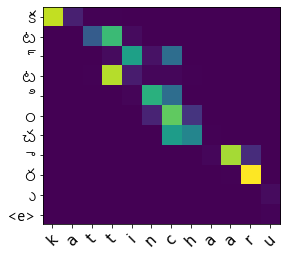

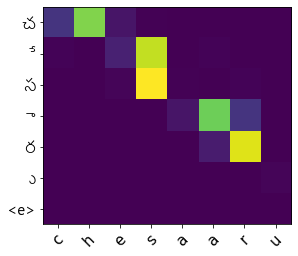

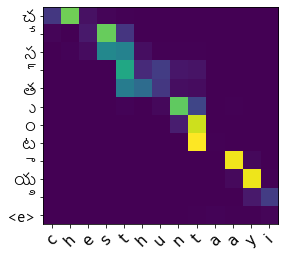

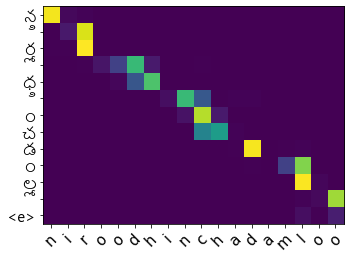

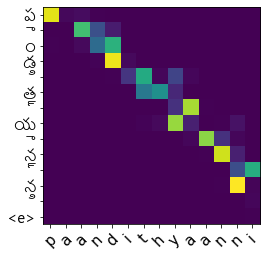

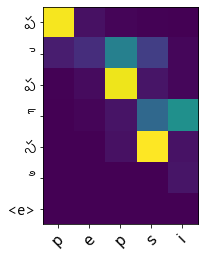

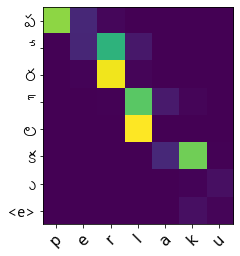

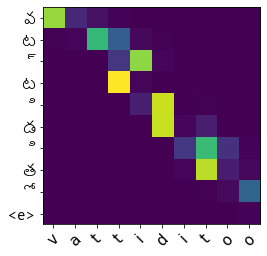

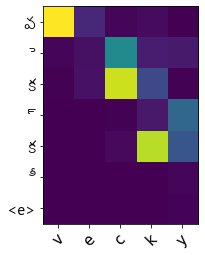

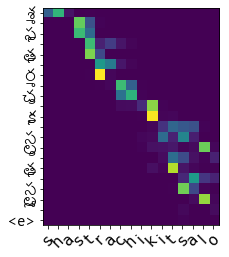

In [ ]:
sweep_id = wandb.sweep(sweep_config_temp, entity="cs21m027_cs21m011", project="DL_ASG_3_final_Attention")
wandb.agent(sweep_id, train)

In [ ]:
Commit this fIleeee......!!!!!!!!!